# Advanced Optimization Techniques

This notebook covers advanced continuous optimization features including:

- **Update history logging** with `log_updates=True` and analysis plots
- **Parallel optimization** using `jax.vmap` for multiple problems
- **Progress tracking** for multiple concurrent optimizations
- **Custom optimizers** and Optax optimizer chains

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ASKabalan/jax-grid-search/blob/main/examples/04-advanced-optimization.ipynb)

## Setup and Imports

In [15]:
# Install the package if running in Colab
try:
    import google.colab
    !pip install jax_grid_search ipywidgets
except ImportError:
    pass  # Not in Colab

import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from jax_grid_search import optimize, ProgressBar
import time
from functools import partial

## 1. Update History Logging and Analysis

The `log_updates=True` parameter enables detailed tracking of the optimization progress, including update norms and objective values at each iteration.

In [ ]:
def challenging_objective(params):
    """
    A challenging objective function with multiple local minima
    and different curvature in different regions.
    """
    x, y = params[0], params[1]
    
    # Global structure
    global_term = (x - 1)**2 + (y + 0.5)**2
    
    # Local oscillations
    local_term = 0.3 * jnp.sin(5*x) * jnp.cos(5*y)
    
    # Asymmetric scaling
    scaling_term = 0.1 * x**4 + 0.05 * y**2
    
    return global_term + local_term + scaling_term

# Test different optimizers with history logging
init_params = jnp.array([3.0, 2.0])  # Start far from optimum
optimizers_to_test = {
    "LBFGS": optax.lbfgs(),
    "Adam": optax.adam(learning_rate=0.1),
}

print(f"Testing update history logging...")
print(f"Initial params: {init_params}")
print(f"Initial objective: {challenging_objective(init_params):.6f}\n")

history_results = {}

for progress_id , (name, optimizer) in enumerate(optimizers_to_test.items()):
    print(f"Running {name} with history logging...")
    
    with ProgressBar() as progress:
        best_params, final_state = optimize(
            init_params=init_params,
            objective_fn=challenging_objective,
            opt=optimizer,
            max_iter=200,
            tol=1e-6,
            progress=progress,
            progress_id=progress_id,
            log_updates=True  # Enable history logging
        )
    
    history_results[name] = {
        'params': best_params,
        'final_value': challenging_objective(best_params),
        'history': final_state.update_history,
        'final_state': final_state
    }
    
    print(f"  Final params: [{best_params[0]:.4f}, {best_params[1]:.4f}]")
    print(f"  Final value: {challenging_objective(best_params):.6f}")
    print(f"  History shape: {final_state.update_history.shape if final_state.update_history is not None else 'None'}\n")

Output()

Testing update history logging...
Initial params: [3. 2.]
Initial objective: 18.386309

Running LBFGS with history logging...


Output()

### Analyzing Optimization History

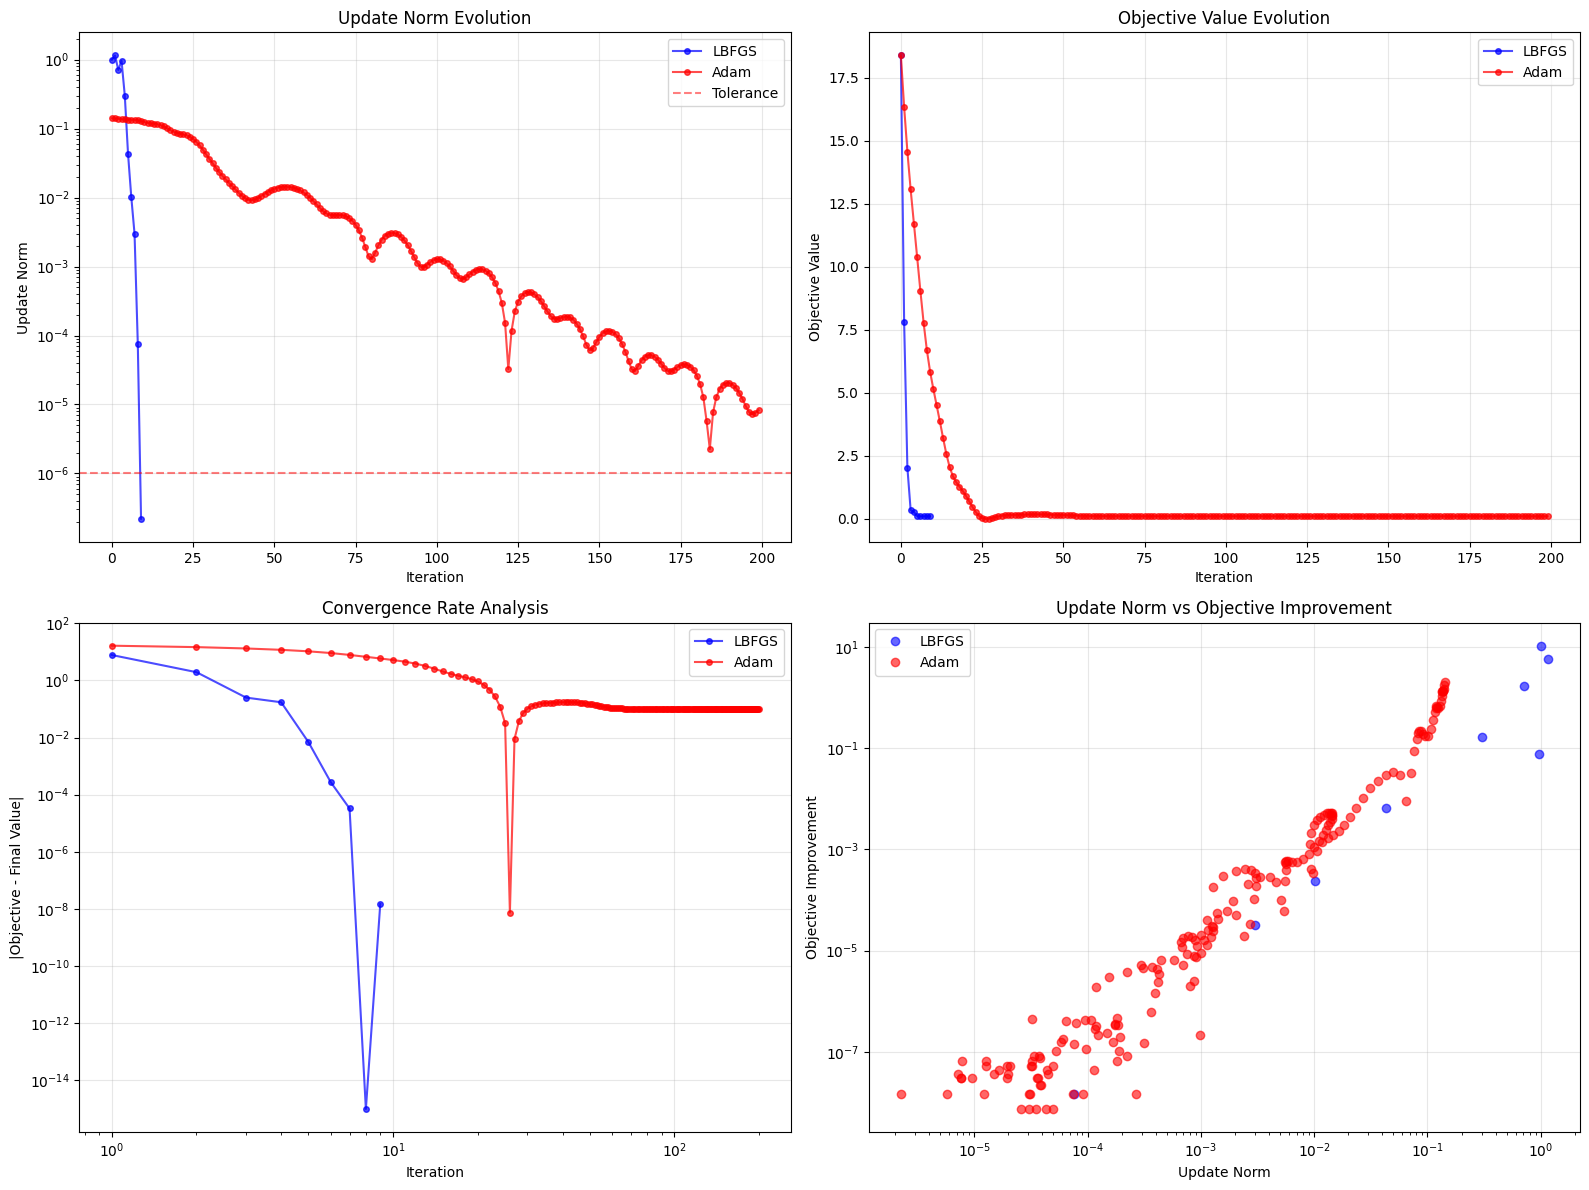


=== OPTIMIZATION HISTORY ANALYSIS ===

LBFGS:
  Iterations: 10
  Initial update norm: 1.00e+00
  Final update norm: 2.20e-07
  Initial objective: 18.386309
  Final objective: 0.101652
  Total improvement: 18.284657

Adam:
  Iterations: 200
  Initial update norm: 1.41e-01
  Final update norm: 8.25e-06
  Initial objective: 18.386309
  Final objective: 0.101653
  Total improvement: 18.284657


In [ ]:
# Create comprehensive history analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

colors = ['blue', 'red', 'green']

# 1. Update norm evolution
for i, (name, result) in enumerate(history_results.items()):
    if result['history'] is not None:
        history = result['history']
        # Find where history becomes zero (optimization stopped)
        nonzero_mask = jnp.any(history > 0, axis=1)
        valid_history = history[nonzero_mask]
        
        iterations = jnp.arange(len(valid_history))
        update_norms = valid_history[:, 0]
        
        ax1.semilogy(iterations, update_norms, 'o-', color=colors[i], 
                    label=f'{name}', alpha=0.7, markersize=4)

ax1.axhline(y=1e-6, color='red', linestyle='--', alpha=0.5, label='Tolerance')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Update Norm')
ax1.set_title('Update Norm Evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Objective value evolution
for i, (name, result) in enumerate(history_results.items()):
    if result['history'] is not None:
        history = result['history']
        nonzero_mask = jnp.any(history > 0, axis=1)
        valid_history = history[nonzero_mask]
        
        iterations = jnp.arange(len(valid_history))
        objective_values = valid_history[:, 1]
        
        ax2.plot(iterations, objective_values, 'o-', color=colors[i], 
                label=f'{name}', alpha=0.7, markersize=4)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Value')
ax2.set_title('Objective Value Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Convergence rate analysis (log-log plot)
for i, (name, result) in enumerate(history_results.items()):
    if result['history'] is not None:
        history = result['history']
        nonzero_mask = jnp.any(history > 0, axis=1)
        valid_history = history[nonzero_mask]
        
        if len(valid_history) > 5:  # Need enough points for analysis
            objective_values = valid_history[:, 1]
            final_value = result['final_value']
            
            # Plot convergence to final value
            convergence_error = jnp.abs(objective_values - final_value)
            # Avoid log(0) by adding small epsilon
            convergence_error = jnp.maximum(convergence_error, 1e-15)
            
            iterations = jnp.arange(len(convergence_error))
            ax3.loglog(iterations[1:], convergence_error[1:], 'o-', color=colors[i], 
                      label=f'{name}', alpha=0.7, markersize=4)

ax3.set_xlabel('Iteration')
ax3.set_ylabel('|Objective - Final Value|')
ax3.set_title('Convergence Rate Analysis')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Update norm vs objective improvement
for i, (name, result) in enumerate(history_results.items()):
    if result['history'] is not None:
        history = result['history']
        nonzero_mask = jnp.any(history > 0, axis=1)
        valid_history = history[nonzero_mask]
        
        if len(valid_history) > 1:
            update_norms = valid_history[:-1, 0]
            objective_values = valid_history[:, 1]
            objective_improvements = jnp.abs(jnp.diff(objective_values))
            
            ax4.loglog(update_norms, objective_improvements, 'o', color=colors[i], 
                      label=f'{name}', alpha=0.6, markersize=6)

ax4.set_xlabel('Update Norm')
ax4.set_ylabel('Objective Improvement')
ax4.set_title('Update Norm vs Objective Improvement')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n=== OPTIMIZATION HISTORY ANALYSIS ===")
for name, result in history_results.items():
    if result['history'] is not None:
        history = result['history']
        nonzero_mask = jnp.any(history > 0, axis=1)
        valid_history = history[nonzero_mask]
        
        print(f"\n{name}:")
        print(f"  Iterations: {len(valid_history)}")
        print(f"  Initial update norm: {valid_history[0, 0]:.2e}")
        print(f"  Final update norm: {valid_history[-1, 0]:.2e}")
        print(f"  Initial objective: {valid_history[0, 1]:.6f}")
        print(f"  Final objective: {valid_history[-1, 1]:.6f}")
        print(f"  Total improvement: {valid_history[0, 1] - valid_history[-1, 1]:.6f}")

## 2. Parallel Optimization with jax.vmap

One of JAX's most powerful features is the ability to vectorize computations. We can optimize multiple problems simultaneously using `jax.vmap`.

In [ ]:
def noisy_quadratic(params, noise_scale, center):
    """
    Quadratic function with configurable noise and center.
    This represents optimizing similar problems with different parameters.
    """
    x, y = params[0], params[1]
    cx, cy = center[0], center[1]
    
    # Basic quadratic with different centers
    base = (x - cx)**2 + (y - cy)**2
    
    # Add noise term with different scales
    noise = noise_scale * jnp.sin(10*x) * jnp.cos(10*y)
    
    return base + noise

# Set up multiple optimization problems
n_problems = 8
init_params = jnp.array([[0.0, 0.0]] * n_problems)  # Same starting point for all

# Different problem configurations
noise_scales = jnp.linspace(0.1, 1.0, n_problems)
centers = jnp.array([[jnp.cos(2*jnp.pi*i/n_problems), jnp.sin(2*jnp.pi*i/n_problems)] 
                    for i in range(n_problems)])

print(f"Setting up {n_problems} parallel optimization problems:")
print(f"Noise scales: {noise_scales}")
print(f"Centers shape: {centers.shape}")
print(f"Centers (first 3): {centers[:3]}")

# Create a function that can handle a single problem
def single_problem_objective(params, noise_scale, center):
    return noisy_quadratic(params, noise_scale, center)

# Test with one problem first
test_params = jnp.array([0.5, -0.3])
test_result = single_problem_objective(test_params, noise_scales[0], centers[0])
print(f"\nTest single problem: {test_result:.4f}")

Setting up 8 parallel optimization problems:
Noise scales: [0.1        0.22857143 0.35714287 0.48571432 0.6142857  0.74285716
 0.8714286  1.        ]
Centers shape: (8, 2)
Centers (first 3): [[ 1.0000000e+00  0.0000000e+00]
 [ 7.0710677e-01  7.0710677e-01]
 [-4.3711388e-08  1.0000000e+00]]

Test single problem: 0.4349


### Running Parallel Optimization

In [ ]:
# Define the parallel optimization function
def solve_single_problem(problem_id, init_param, noise_scale, center):
    """
    Solve a single optimization problem.
    This function will be vmapped to solve multiple problems in parallel.
    """
    # Create objective function for this specific problem
    def objective(params):
        return single_problem_objective(params, noise_scale, center)
    
    # Use Adam optimizer for parallel problems
    optimizer = optax.adam(learning_rate=0.1)
    
    # Optimize with progress tracking
    with ProgressBar() as progress:
        best_params, final_state = optimize(
            init_params=init_param,
            objective_fn=objective,
            opt=optimizer,
            max_iter=150,
            tol=1e-6,
            progress=progress,
            progress_id=problem_id  # Unique ID for each problem
        )
    
    return best_params, final_state.value

print("Running parallel optimization...")
print("Each problem will have its own progress bar\n")

# Use vmap to vectorize the solve function
solve_all_problems = jax.vmap(solve_single_problem, in_axes=(0, 0, 0, 0))

# Generate problem IDs
problem_ids = jnp.arange(n_problems)

# Run all optimizations in parallel
start_time = time.time()
all_best_params, all_final_values = solve_all_problems(
    problem_ids, init_params, noise_scales, centers
)
end_time = time.time()

print(f"\nParallel optimization completed in {end_time - start_time:.2f} seconds")
print(f"Solved {n_problems} problems simultaneously\n")

# Analyze results
print("Results summary:")
for i in range(n_problems):
    center = centers[i]
    found_params = all_best_params[i]
    final_value = all_final_values[i]
    error = jnp.linalg.norm(found_params - center)
    
    print(f"Problem {i}: Center=({center[0]:.2f},{center[1]:.2f}), "
          f"Found=({found_params[0]:.2f},{found_params[1]:.2f}), "
          f"Error={error:.3f}, Value={final_value:.4f}")

Output()

Running parallel optimization...
Each problem will have its own progress bar




Parallel optimization completed in 1.87 seconds
Solved 8 problems simultaneously

Results summary:
Problem 0: Center=(1.00,0.00), Found=(1.08,0.00), Error=0.083, Value=-0.0917
Problem 1: Center=(0.71,0.71), Found=(0.78,0.92), Error=0.228, Value=-0.1720
Problem 2: Center=(-0.00,1.00), Found=(-0.15,0.06), Error=0.955, Value=0.6117
Problem 3: Center=(-0.71,0.71), Found=(-0.18,0.03), Error=0.859, Value=0.2844
Problem 4: Center=(-1.00,-0.00), Found=(-0.18,0.00), Error=0.816, Value=0.0737
Problem 5: Center=(-0.71,-0.71), Found=(-0.17,-0.02), Error=0.872, Value=0.0384
Problem 6: Center=(0.00,-1.00), Found=(-0.15,-0.02), Error=0.989, Value=0.1301
Problem 7: Center=(0.71,-0.71), Found=(-0.14,-0.01), Error=1.094, Value=0.2222


## 3. Custom Optimizers and Optax Chains

Optax allows you to create sophisticated optimization strategies by combining multiple optimizers and transformations.

In [ ]:
def complex_landscape(params):
    """
    A complex optimization landscape that benefits from sophisticated optimizers.
    """
    x, y = params[0], params[1]
    
    # Multiple scales of variation
    coarse = (x - 1)**2 + (y + 0.5)**2
    medium = 0.5 * jnp.sin(3*x) * jnp.cos(3*y)
    fine = 0.1 * jnp.sin(20*x) * jnp.cos(20*y)
    
    # Asymmetric conditioning
    conditioning = 0.1 * (x**4 + 0.01 * y**2)
    
    return coarse + medium + fine + conditioning

# Define custom optimizer configurations
custom_optimizers = {
    "Basic Adam": optax.adam(learning_rate=0.1),
    
    "Adam + Clipping": optax.chain(
        optax.clip_by_global_norm(1.0),  # Gradient clipping
        optax.adam(learning_rate=0.1)
    ),
}

print("Testing custom optimizer configurations...\n")

init_params = jnp.array([3.0, -2.0])  # Challenging starting point
custom_results = {}

for id , (name, optimizer) in enumerate(custom_optimizers.items()):
    print(f"Testing {name}...")
    
    start_time = time.time()
    with ProgressBar() as progress:
        best_params, final_state = optimize(
            init_params=init_params,
            objective_fn=complex_landscape,
            opt=optimizer,
            max_iter=300,
            tol=1e-8,
            progress=progress,
            progress_id=id,
            log_updates=True
        )
    end_time = time.time()
    
    final_value = complex_landscape(best_params)
    
    custom_results[name] = {
        'params': best_params,
        'value': final_value,
        'time': end_time - start_time,
        'history': final_state.update_history,
        'update_norm': final_state.update_norm
    }
    
    print(f"  Final params: [{best_params[0]:.4f}, {best_params[1]:.4f}]")
    print(f"  Final value: {final_value:.6f}")
    print(f"  Time: {end_time - start_time:.2f}s")
    print(f"  Final update norm: {final_state.update_norm:.2e}\n")

Output()

Testing custom optimizer configurations...

Testing Basic Adam...


Output()

  Final params: [1.1738, -0.3123]
  Final value: 0.046015
  Time: 0.78s
  Final update norm: 2.31e-09

Testing Adam + Clipping...


  Final params: [1.1738, -0.3123]
  Final value: 0.046015
  Time: 0.67s
  Final update norm: 1.69e-07



### Comparing Custom Optimizers

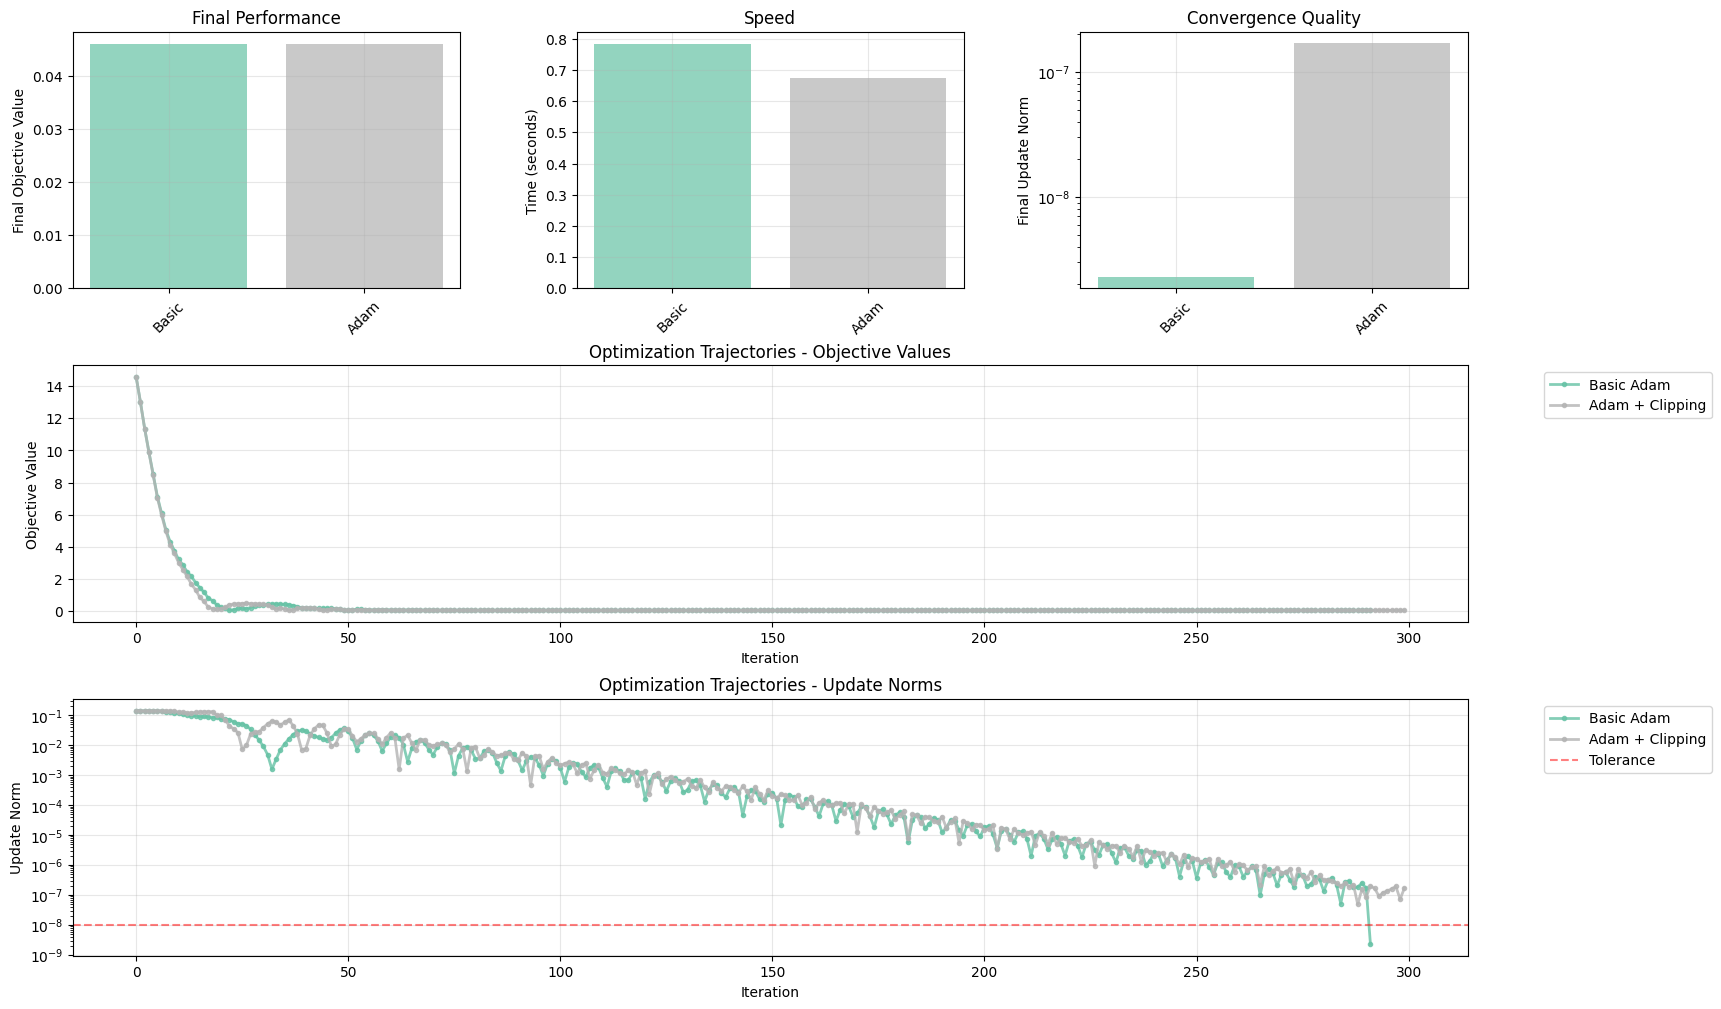


=== CUSTOM OPTIMIZER PERFORMANCE RANKING ===

1. BY FINAL OBJECTIVE VALUE (lower is better):
   1. Basic Adam: 0.046015
   2. Adam + Clipping: 0.046015

2. BY SPEED (lower is better):
   1. Adam + Clipping: 0.67s
   2. Basic Adam: 0.78s

3. BY CONVERGENCE QUALITY (lower update norm is better):
   1. Basic Adam: 2.31e-09
   2. Adam + Clipping: 1.69e-07

=== KEY INSIGHTS ===
• Gradient clipping prevents exploding gradients in complex landscapes
• Learning rate scheduling can improve convergence
• AdamW with weight decay helps with generalization
• Multi-step chains allow fine-tuned optimization strategies
• The best optimizer depends on your specific problem characteristics


In [ ]:
# Comprehensive comparison of custom optimizers
fig = plt.figure(figsize=(18, 12))

# Create a complex subplot layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])
ax5 = fig.add_subplot(gs[2, :])

optimizer_names = list(custom_results.keys())
n_optimizers = len(optimizer_names)
colors = plt.cm.Set2(np.linspace(0, 1, n_optimizers))

# 1. Final objective values
values = [custom_results[name]['value'] for name in optimizer_names]
bars1 = ax1.bar(range(n_optimizers), values, color=colors, alpha=0.7)
ax1.set_xticks(range(n_optimizers))
ax1.set_xticklabels([name.split()[0] for name in optimizer_names], rotation=45)
ax1.set_ylabel('Final Objective Value')
ax1.set_title('Final Performance')
ax1.grid(True, alpha=0.3)

# 2. Computation time
times = [custom_results[name]['time'] for name in optimizer_names]
bars2 = ax2.bar(range(n_optimizers), times, color=colors, alpha=0.7)
ax2.set_xticks(range(n_optimizers))
ax2.set_xticklabels([name.split()[0] for name in optimizer_names], rotation=45)
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Speed')
ax2.grid(True, alpha=0.3)

# 3. Final update norms
update_norms = [custom_results[name]['update_norm'] for name in optimizer_names]
bars3 = ax3.bar(range(n_optimizers), update_norms, color=colors, alpha=0.7)
ax3.set_xticks(range(n_optimizers))
ax3.set_xticklabels([name.split()[0] for name in optimizer_names], rotation=45)
ax3.set_ylabel('Final Update Norm')
ax3.set_title('Convergence Quality')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 4. Optimization trajectories (objective values)
for i, name in enumerate(optimizer_names):
    history = custom_results[name]['history']
    if history is not None:
        nonzero_mask = jnp.any(history > 0, axis=1)
        valid_history = history[nonzero_mask]
        
        iterations = jnp.arange(len(valid_history))
        objective_values = valid_history[:, 1]
        
        ax4.plot(iterations, objective_values, 'o-', color=colors[i], 
                label=name, alpha=0.8, markersize=3, linewidth=2)

ax4.set_xlabel('Iteration')
ax4.set_ylabel('Objective Value')
ax4.set_title('Optimization Trajectories - Objective Values')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

# 5. Update norm trajectories
for i, name in enumerate(optimizer_names):
    history = custom_results[name]['history']
    if history is not None:
        nonzero_mask = jnp.any(history > 0, axis=1)
        valid_history = history[nonzero_mask]
        
        iterations = jnp.arange(len(valid_history))
        update_norms = valid_history[:, 0]
        
        ax5.semilogy(iterations, update_norms, 'o-', color=colors[i], 
                    label=name, alpha=0.8, markersize=3, linewidth=2)

ax5.axhline(y=1e-8, color='red', linestyle='--', alpha=0.5, label='Tolerance')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Update Norm')
ax5.set_title('Optimization Trajectories - Update Norms')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(True, alpha=0.3)

plt.show()

# Performance ranking
print("\n=== CUSTOM OPTIMIZER PERFORMANCE RANKING ===")
print("\n1. BY FINAL OBJECTIVE VALUE (lower is better):")
value_ranking = sorted(optimizer_names, key=lambda x: custom_results[x]['value'])
for i, name in enumerate(value_ranking):
    print(f"   {i+1}. {name}: {custom_results[name]['value']:.6f}")

print("\n2. BY SPEED (lower is better):")
speed_ranking = sorted(optimizer_names, key=lambda x: custom_results[x]['time'])
for i, name in enumerate(speed_ranking):
    print(f"   {i+1}. {name}: {custom_results[name]['time']:.2f}s")

print("\n3. BY CONVERGENCE QUALITY (lower update norm is better):")
convergence_ranking = sorted(optimizer_names, key=lambda x: custom_results[x]['update_norm'])
for i, name in enumerate(convergence_ranking):
    print(f"   {i+1}. {name}: {custom_results[name]['update_norm']:.2e}")
